In [48]:
!pip install pandas kaggle seaborn matplotlib scikit-learn[metrics] torch torchvision torchaudio torchsummary
# To determine which PyTorch version to use go here: https://pytorch.org/get-started/locally/
# I am using stable, linux, pip, python, CUDA 12.4


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
#!kaggle datasets download -d fantacher/neu-metal-surface-defects-data

Dataset URL: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data
License(s): other
neu-metal-surface-defects-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [50]:
#!unzip neu-metal-surface-defects-data

Archive:  neu-metal-surface-defects-data.zip
replace NEU Metal Surface Defects Data/Thumbs.db? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Project Description
TODO

## Goals
TODO

## Tools and Resoruces
Pytorch classifier tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Guide to freezing layers: https://medium.com/we-talk-data/guide-to-freezing-layers-in-pytorch-best-practices-and-practical-examples-8e644e7a9598

RezNext page: https://pytorch.org/hub/pytorch_vision_resnext/

Working from this project as a base to learn PyTorch: https://www.kaggle.com/code/bensonlin0731/image-classifier

In [70]:
import pathlib
import pathlib as path
import random as r

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

print('CUDA available:',torch.cuda.is_available())

seed = 1


CUDA available: True


## Dataset Documentation

This dataset contains three folders: train, test, valid. The training folder contains six defect type subfolders that have 276 image files in each folder. The test and validation folders contain six defect type subfolders that have 12 images in each folder.

These 6 defect modes in this dataset are:
* **Inclusion**: A nonuniform material was presssed or forged into the material. They can be loose and easily removed, or very tightly bound.
* **Crazing**: Visible surface cracking, typically many cracks in one region due to tension stresses.
* **Patches**: A patch of nonuniform material
* **Pitting**: Penetrating pockmarks and divots caused by corrosion 
* **Scratches**: Abrasion marking
* **Rolled**: Material that had mill scale pressed into it during the rolling process.

Source: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data/data

"This dataset was downloaded from the NEU Metal Surface Defects Database, which collects six kinds of typical surface defects of hot-rolled steel strips: rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In), and scratches (Sc). The database includes 1,800 grayscale images and 300 samples, each of six typical surface defects."

In [71]:
data_root = r'NEU Metal Surface Defects Data'
cwd = pathlib.Path.cwd()

if cwd.name == 'manufac_defect_detection':
    print("Path is project root")
else:
    print("Recomend navigating to the project root in terminal and opening your chosen idea via a command such as 'code .'")
    raise NameError('Please correct current working directory to the project root')

train_dir = path.PurePath(cwd, data_root, 'train')
test_dir = path.PurePath(cwd, data_root, 'test')
valid_dir = path.PurePath(cwd, data_root, 'valid')

Path is project root


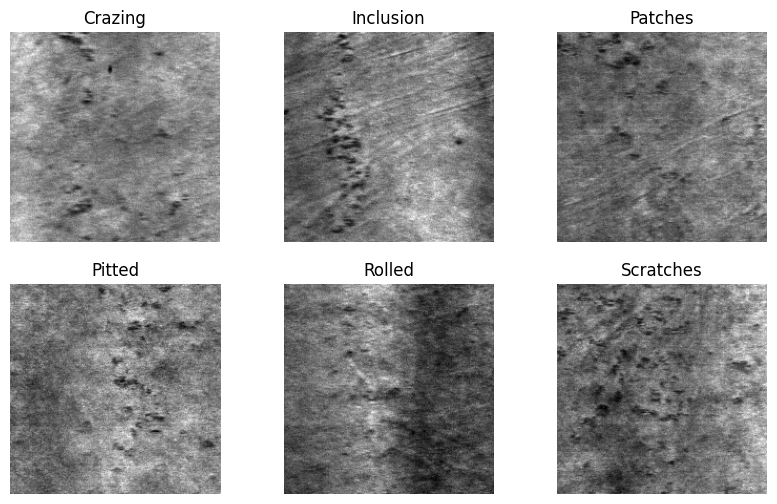

In [72]:
# TODO: Display random image from each of the 6 types of defect.
def show_rand_image_of_each(directory):

    class_names = [child.name for child in path.Path(directory).iterdir()]
    num_rows = 2
    num_columns = 3
    fig, axarr = plt.subplots(num_rows, num_columns, figsize= (10,6))

    for idx, class_name in enumerate(class_names):
        img_path = r.choice([x for x in path.Path(train_dir, 'Rolled').iterdir()])
        img = mpimg.imread(img_path)
        i = idx // num_columns
        j = idx % num_columns
        axarr[i, j].imshow(img, cmap = 'gray')
        axarr[i, j].set_title(class_name)
        axarr[i, j].axis('off')

show_rand_image_of_each(train_dir)

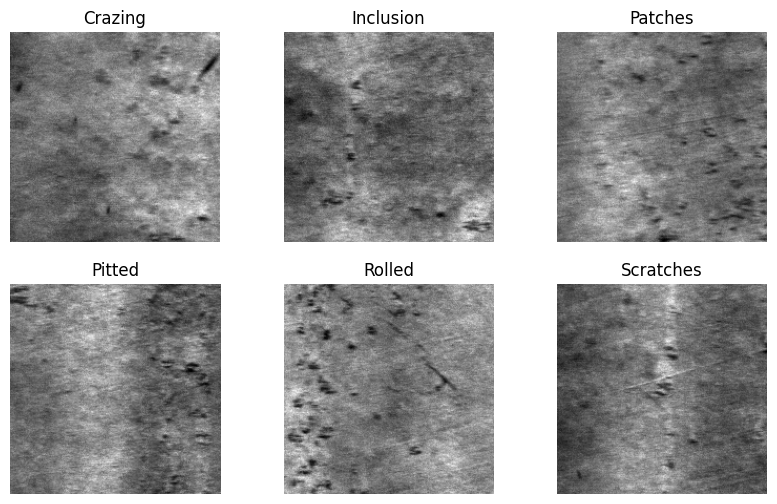

In [73]:
show_rand_image_of_each(test_dir)

In [74]:
defect_dirs = [dir.name for dir in path.Path(train_dir).iterdir()]
defect_dirs

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

# Image Preprocessing

1. Prepare the images for our network model
2. Augment the training data with transformations such as rotation and flipping to prevent overfitting

Data Augmentation is essential to avoid overtraining on a regular orientation that may or may not appear in the training dataset. 

In [75]:
# TODO: Image Preprocessing
# minimum transforms for Valid and train.
#   resize, horz flip, color jitter, 30deg rotate
# Then to tensor and normalize 

In [76]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), #default is 50% mirrored
        transforms.ColorJitter(), # randomly adjust brightness, contrast, hue, saturation of images
        transforms.RandomRotation(30), # random rotation of up to +- 30 deg
        transforms.ToTensor(), # turn from image into tensor range [0,1] for each value 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # transform tensor to range [-1,1]
    ]),
    #same process for validated set
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), 
        transforms.ColorJitter(), 
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [77]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid'])
}
print('Training data length:', len(data['train']))
print('Validation data length:', len(data['valid']))

Training data length: 1656
Validation data length: 72


In [78]:
BATCH_SIZE = 32
NUM_CLASSES = 6
train_loader = DataLoader(data['train'], 
                          batch_size=BATCH_SIZE, # work on 64 images per epoch
                          shuffle=True) # Dont need fine grained control of a sampler
                                        # True means images are shuffled each epoch


val_loader = DataLoader(data['valid'],  # same as for trainingset
                          batch_size=BATCH_SIZE,
                          shuffle=True)

# Load Pretrained model (resnet-50)

Training a new model from scratch is expensive. If possible use a pre-trained model and transfer learning to reduce model training costs.

Pre-trained models are a staple in computer-vision work, as they have been trained by large companies on extremely large datasets as general purpose tools. The weights from this general training will jumpstart more specific computer vision learning tasks tremendously.

Transfer learning is particularly useful when the dataset of interest is small. The model may fail to generalize without a larger pre-train base weights.  

Using the ResNext pretrained model from the PyTorch model database: https://pytorch.org/hub/pytorch_vision_resnext/

In [79]:
cuda_actv =  torch.cuda.is_available()
print("CUDA Available:", cuda_actv)
device = torch.device("cuda:0" if cuda_actv else "cpu")
model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V2).to(device) #pretrain the resnet model to a stable set of weights
summary(model, (3, 224, 224))

CUDA Available: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-

# Build and Train the model(s)

In [80]:
# TODO: Freeze output layers
# TODO: compare a few cases of unfrozen layers (learning)
    # 3 unfrozen in, out, and both
for params in model.parameters():
    params.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Sequential(    #overrides for 1 dense layer to output classification
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, NUM_CLASSES)
)

model = model.to(device)

## Define loss and optimizer

In [81]:
metric = torch.nn.CrossEntropyLoss() # standard for classification
optimizer = torch.optim.SGD(model.fc.parameters(), 
                            lr=0.001, # slightly slow learning rate to differentiate defects better
                            momentum = 0.9) # standard momentum to escapt local mins and smooth loss curves

## Training

In [ ]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0

    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = metric(outputs, labels)
        loss.backward() # reverse propagate loss
        optimizer.step()
        train_loss += loss.item() * images.size(0) # return tensor value as std python number, only works for single element tensor
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

    model.eval()
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = metric(outputs, labels)
        val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/50], Training Loss: 0.025752, Validation Loss: 0.2082
Epoch [2/50], Training Loss: 0.026156, Validation Loss: 0.2114
Epoch [3/50], Training Loss: 0.025774, Validation Loss: 0.2108
Epoch [4/50], Training Loss: 0.025813, Validation Loss: 0.2088
Epoch [5/50], Training Loss: 0.025603, Validation Loss: 0.2098
Epoch [6/50], Training Loss: 0.025770, Validation Loss: 0.2074
Epoch [7/50], Training Loss: 0.025876, Validation Loss: 0.2080
Epoch [8/50], Training Loss: 0.025737, Validation Loss: 0.2063
Epoch [9/50], Training Loss: 0.025500, Validation Loss: 0.2060
Epoch [10/50], Training Loss: 0.025439, Validation Loss: 0.2041
Epoch [11/50], Training Loss: 0.025597, Validation Loss: 0.2030
Epoch [12/50], Training Loss: 0.025176, Validation Loss: 0.2013
Epoch [13/50], Training Loss: 0.025275, Validation Loss: 0.2008
Epoch [14/50], Training Loss: 0.024281, Validation Loss: 0.1991
Epoch [15/50], Training Loss: 0.024229, Validation Loss: 0.1874
Epoch [16/50], Training Loss: 0.022944, Validatio

# Test model vs test dataset

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_data = datasets.ImageFolder(test_dir, transform = test_transforms)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []

    for images, labels in test_loader: # load each batch per cycle
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1) # format probability, index. max takes highest probability

        total += labels.size(0)
        correct += (predicted == labels).sum().item() # sum true values then get as python obj from torch obj

        y_pred.extend(predicted.cpu().numpy()) # extend used to unpack and add a list like item to the list
        y_true.extend(labels.cpu().numpy())
    print(f'Test Accuracy: {round((correct / total * 100), 3)}%')


Test Accuracy: 16.667%
